In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bayesian_statistics.models.composition import NadarayaWatsonEstimator
from bayesian_statistics.models.config import Model3Config, Model3Pipeline
from bayesian_statistics.models.evaluation import LOOCVConfig, UnifiedLOOCVEvaluator
from bayesian_statistics.models.visualization import ObsidianVisualizer

# 1. 設定
config = Model3Config(
    data_dir="/home/ohta/dev/bayesian_statistics/data",
    nw_sigma=1000,
)

# 2. 前処理
pipeline = Model3Pipeline(config)
preprocessor = pipeline.run_preprocessing()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


=== 前処理を開始 ===
データを読み込んでいます...
標高データ: (1357520, 42)
黒曜石データ: (30070, 11)
遺跡データ: (274, 49)


In [2]:
from bayesian_statistics.models.composition import BayesianSpatialMultinomialModel

spatial_model = BayesianSpatialMultinomialModel(
    variable_names=config.nw_variable_names,  # 使用する説明変数
    prior_sigma=0.3,  # 事前分布の標準偏差
    n_draws=2000,  # MCMC描画数
    n_tune=500,  # チューニング回数
    random_seed=42,  # 乱数シード
)

# 全時期（0-4）のモデル学習
results = spatial_model.fit(preprocessor)

=== ベイズ空間多項回帰学習開始（全時期） ===
=== 時期0の学習開始 ===
学習用データ形状: X=(52, 8), Y=(52, 4)
産地別合計: [1019, 342, 90, 15]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 10 seconds.


時期0: 学習完了 (Rhat最大=1.000)
=== 時期1の学習開始 ===
学習用データ形状: X=(61, 8), Y=(61, 4)
産地別合計: [2471, 1690, 111, 20]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 12 seconds.


時期1: 学習完了 (Rhat最大=1.000)
=== 時期2の学習開始 ===
学習用データ形状: X=(146, 8), Y=(146, 4)
産地別合計: [10277, 4626, 442, 128]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 14 seconds.


時期2: 学習完了 (Rhat最大=1.000)
=== 時期3の学習開始 ===
学習用データ形状: X=(59, 8), Y=(59, 4)
産地別合計: [1189, 2998, 596, 585]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 14 seconds.


時期3: 学習完了 (Rhat最大=1.000)
=== 時期4の学習開始 ===
学習用データ形状: X=(18, 8), Y=(18, 4)
産地別合計: [400, 590, 88, 78]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 9 seconds.


時期4: 学習完了 (Rhat最大=1.000)
=== 学習完了: 5時期のモデル ===


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

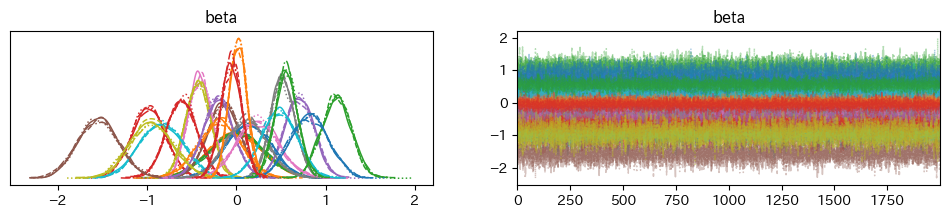

In [3]:
import arviz as az

az.plot_trace(results[0]["trace"])

In [4]:
results[0].keys()

dict_keys(['X_train', 'Y_train', 'site_ids', 'X_mean', 'X_std', 'trace', 'summary', 'rhat_max'])

In [5]:
results[0]["X_train"].shape, results[0]["Y_train"].shape

((52, 8), (52, 4))

In [6]:
config.nw_variable_names

['average_elevation',
 'average_slope_angle',
 'cost_kouzu',
 'cost_shinshu',
 'cost_hakone',
 'cost_takahara',
 'cost_river']

In [7]:
results[0]["summary"]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.003,0.297,-0.549,0.559,0.003,0.004,10232.0,5777.0,1.0
"beta[0, 1]",-0.005,0.301,-0.570,0.559,0.003,0.004,12655.0,4758.0,1.0
"beta[0, 2]",0.002,0.301,-0.539,0.602,0.003,0.004,12182.0,5897.0,1.0
"beta[1, 0]",-0.980,0.188,-1.339,-0.637,0.002,0.001,8679.0,6135.0,1.0
"beta[1, 1]",0.705,0.165,0.401,1.021,0.002,0.001,8956.0,6439.0,1.0
"beta[1, 2]",-0.142,0.181,-0.489,0.190,0.002,0.002,9377.0,6552.0,1.0
"beta[2, 0]",-0.405,0.134,-0.652,-0.153,0.001,0.001,8982.0,6432.0,1.0
"beta[2, 1]",0.522,0.134,0.277,0.783,0.001,0.001,9545.0,6661.0,1.0
"beta[2, 2]",-0.426,0.142,-0.682,-0.154,0.001,0.001,9285.0,6328.0,1.0
"beta[3, 0]",-0.836,0.241,-1.272,-0.379,0.003,0.002,8991.0,6128.0,1.0


In [8]:
# 遺跡での予測（時期別に分かれたDict形式）
site_ratios = spatial_model.predict_site_ratios(preprocessor)
# 返り値: {"0": DataFrame, "1": DataFrame, ...}

# グリッドでの予測（全時期・全産地のカラムを含む）
grid_ratios = spatial_model.predict_grid_ratios(preprocessor)
# 返り値: pl.DataFrame with columns ['x', 'y', 'ratio_0_神津島', 'ratio_1_神津島', ...]

print(spatial_model.model_name)  # "BayesianSpatialRegression"

# 学習結果の確認
for period, period_result in spatial_model.results.items():
    print(f"時期{period}: Rhat最大値 = {period_result['rhat_max']:.3f}")

100%|██████████| 5/5 [00:00<00:00, 2520.92it/s]


BayesianSpatialRegression
時期0: Rhat最大値 = 1.000
時期1: Rhat最大値 = 1.000
時期2: Rhat最大値 = 1.000
時期3: Rhat最大値 = 1.000
時期4: Rhat最大値 = 1.000


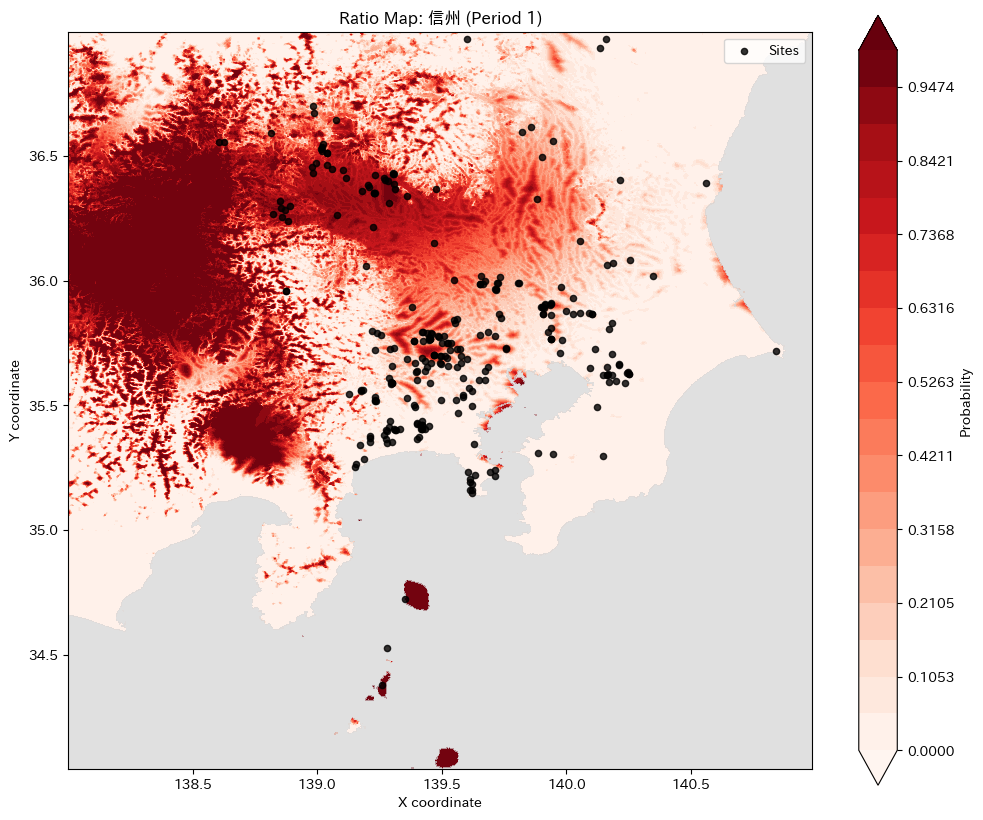

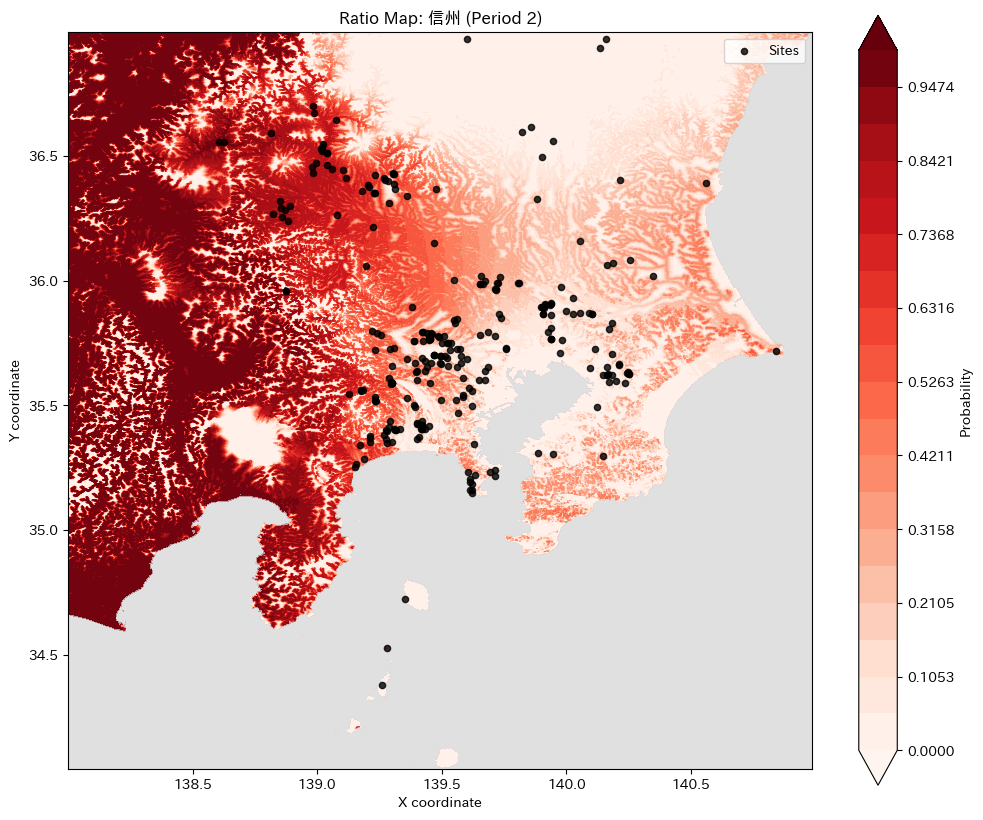

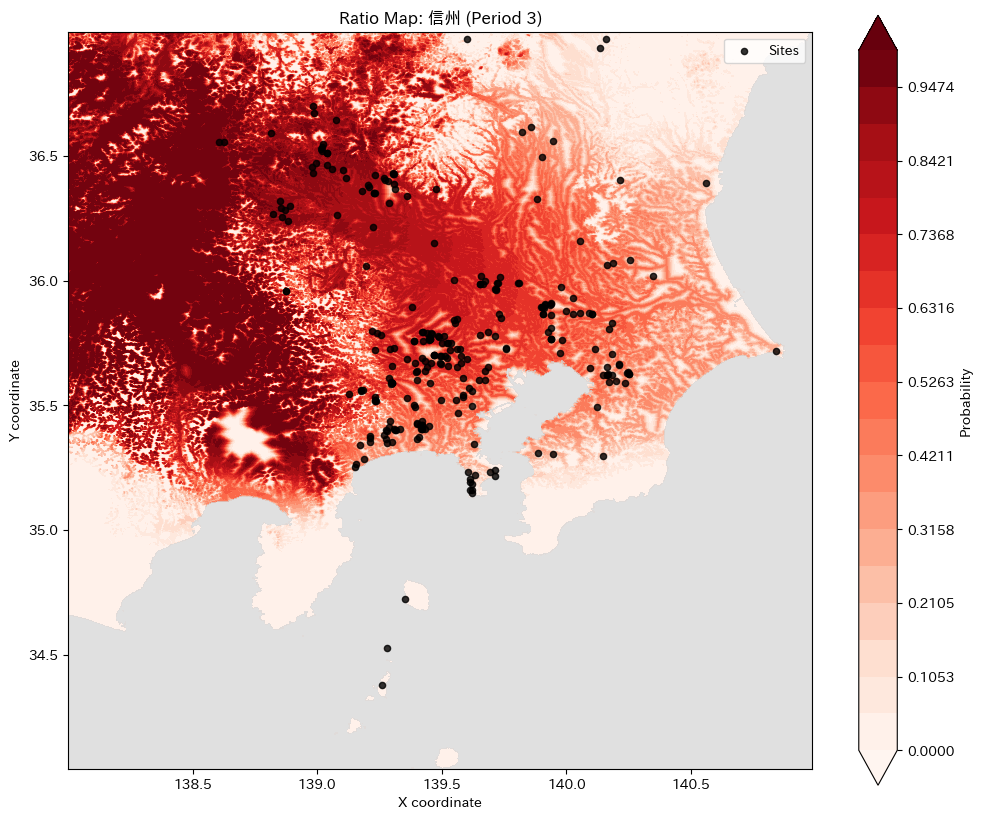

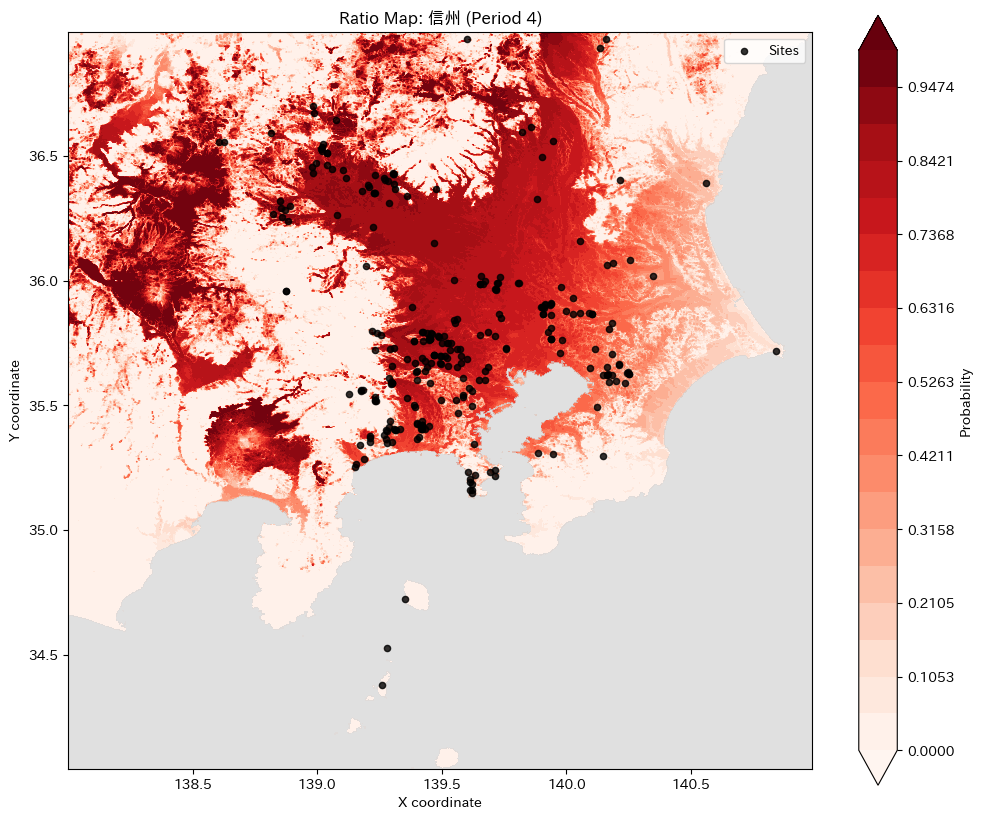

In [9]:
for period in [1, 2, 3, 4]:
    # 新しいメソッドで可視化
    fig, ax = ObsidianVisualizer.plot_ratio_map_from_grid_data(
        preprocessor.df_elevation,
        preprocessor.df_sites,
        grid_ratios,
        period=period,
        origin="信州",
    )
    plt.show()